# import

In [38]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji,   # 載入 emoji 圖像
    load_cfd_npy
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tf_np import (
    to_rgb,
    to_rgba,
    to_alpha,
    crop_and_resize,
    get_random_cfd_slices,
    get_random_cfd_slices_pair
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

- state
  - [Static Fields] (Z, Y, X, C) = (32, 82, 83, 7)
  - [Dynamic Fields] (T, Z, Y, X, C) = (32, 32, 82, 83, 8)
  - Static: X, Y, Z, Xnorm, Ynorm, Znorm, occupancy
  - Dynamic: Ux, Uy, Uz, Umag, p, k, nut, epsilon

- Sampling Bounds:
  - X: -12.312 ~ 28.375
  - Y: -12.187 ~ 28.124
  - Z: 0.000 ~ 15.500

- Sampling Dimensions:
  - X: 83, Y: 82, Z: 32

- Cell size: 0.500 m
- Time steps processed: 32

In [39]:
CELL_SIZE = 0.5  # CFD 網格尺寸 (m)
DYNAMIC_FIELDS_NAMES = ['Ux', 'Uy', 'Uz', 'Umag', 'p', 'k', 'nut', 'epsilon']
STATIC_FIELDS_NAMES = ['X', 'Y', 'Z', 'Xnorm', 'Ynorm', 'Znorm', 'occupancy']

(35, 32, 105, 103, 8)
(32, 105, 103, 7)


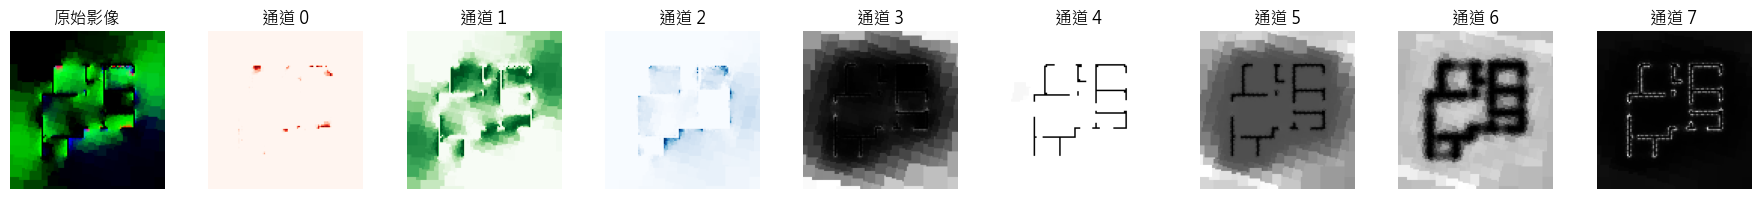

In [40]:
# 載入檔案
dynamic_fields = load_cfd_npy('../dataset/FP030_speed1_dir165/FP030_speed1_dir165_dynamic_fields.npy')
static_fields = load_cfd_npy('../dataset/FP030_speed1_dir165/FP030_speed1_dir165_static_fields.npy')
print(dynamic_fields.shape)
print(static_fields.shape)


plt_HWC_split_channels(dynamic_fields[0,3,:,:,:], histogram=False, max_channels=None)

(35, 32, 105, 103, 3)


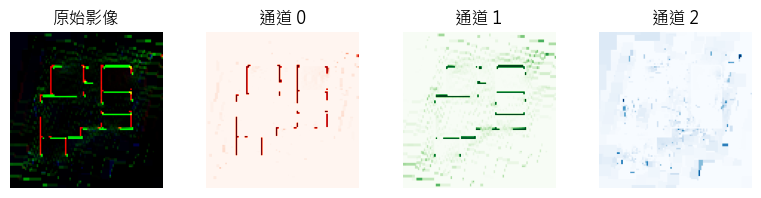

In [41]:
def compute_pressure_force(data, rho=1.225, vector=True):
    """
    計算 simpleFoam 壓力梯度力 Fp。
    
    參數：
    ----------
    data : np.array
        五維陣列 (time, z, y, x, C)，C 為各物理量
    p_index : int
        動壓 p* 在最後一維 C 的索引
    dx, dy, dz : float
        x, y, z 方向格距 (m)
    rho : float
        流體密度 (kg/m^3)，預設空氣 1.225
    vector : bool
        是否回傳向量場 (True) 或模長 (False)
        
    回傳：
    ----------
    Fp : np.array
        壓力梯度力
        - vector=True : shape = (time, z, y, x, 3)
        - vector=False: shape = (time, z, y, x, 1)
    """
    # 取出kinematic pressure
    p_index = DYNAMIC_FIELDS_NAMES.index("p")
    p_star = data[..., p_index]  # shape = (time, z, y, x)

    dz, dy, dx = CELL_SIZE,CELL_SIZE,CELL_SIZE  # 假設各方向格距相同
    
    # 計算梯度
    dpdz, dpdy, dpdx = np.gradient(p_star, dz, dy, dx, axis=(1,2,3))
    
    # 計算壓力梯度力分量
    Fp_x = -rho * dpdx
    Fp_y = -rho * dpdy
    Fp_z = -rho * dpdz
    
    if vector:
        # 組成向量
        Fp_vec = np.stack([Fp_x, Fp_y, Fp_z], axis=-1)  # shape = (time, z, y, x, 3)
        return Fp_vec
    else:
        # 計算模長
        Fp_mag = np.sqrt(Fp_x**2 + Fp_y**2 + Fp_z**2)
        Fp_mag = Fp_mag[..., np.newaxis]  # shape = (time, z, y, x, 1)
        return Fp_mag
F_pressure = compute_pressure_force(dynamic_fields, rho=1.225, vector=True)
print(F_pressure.shape)
plt_HWC_split_channels(F_pressure[0,3,:,:,:], histogram=False, max_channels=None)

(35, 32, 105, 103, 3)


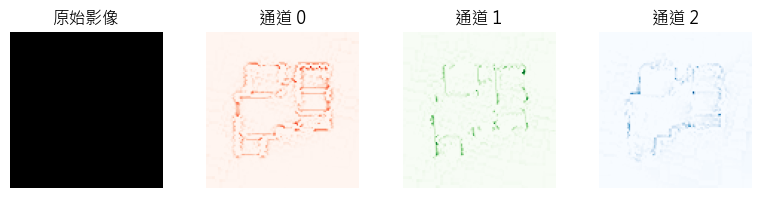

In [42]:
def compute_viscous_force(data, mu=1.0):
    """
    計算黏滯項 F_nu = mu * ∇²u
    
    Parameters
    ----------
    data : np.ndarray
        shape = (time, z, y, x, C)，包含多個物理量
    mu : float
        動黏度 (Pa·s)
    
    Returns
    -------
    F_nu : np.ndarray
        shape = (time, z, y, x, 3)，黏滯力向量
    """
    dz, dy, dx = CELL_SIZE,CELL_SIZE,CELL_SIZE  # 假設各方向格距相同

    # 取速度分量
    Ux = data[..., DYNAMIC_FIELDS_NAMES.index("Ux")]
    Uy = data[..., DYNAMIC_FIELDS_NAMES.index("Uy")]
    Uz = data[..., DYNAMIC_FIELDS_NAMES.index("Uz")]

    # 二階偏導數 (拉普拉斯)
    d2Ux_dx2 = np.gradient(np.gradient(Ux, dx, axis=3), dx, axis=3)
    d2Ux_dy2 = np.gradient(np.gradient(Ux, dy, axis=2), dy, axis=2)
    d2Ux_dz2 = np.gradient(np.gradient(Ux, dz, axis=1), dz, axis=1)

    d2Uy_dx2 = np.gradient(np.gradient(Uy, dx, axis=3), dx, axis=3)
    d2Uy_dy2 = np.gradient(np.gradient(Uy, dy, axis=2), dy, axis=2)
    d2Uy_dz2 = np.gradient(np.gradient(Uy, dz, axis=1), dz, axis=1)

    d2Uz_dx2 = np.gradient(np.gradient(Uz, dx, axis=3), dx, axis=3)
    d2Uz_dy2 = np.gradient(np.gradient(Uz, dy, axis=2), dy, axis=2)
    d2Uz_dz2 = np.gradient(np.gradient(Uz, dz, axis=1), dz, axis=1)

    # 計算拉普拉斯
    Laplace_Ux = d2Ux_dx2 + d2Ux_dy2 + d2Ux_dz2
    Laplace_Uy = d2Uy_dx2 + d2Uy_dy2 + d2Uy_dz2
    Laplace_Uz = d2Uz_dx2 + d2Uz_dy2 + d2Uz_dz2

    # 黏滯力
    F_nu = mu * np.stack([Laplace_Ux, Laplace_Uy, Laplace_Uz], axis=-1)
    return F_nu

F_viscous = compute_viscous_force(dynamic_fields, mu=1.8e-5)
print(F_viscous.shape)
plt_HWC_split_channels(F_viscous[0,3,:,:,:], histogram=False, max_channels=None)


(35, 32, 105, 103, 3)


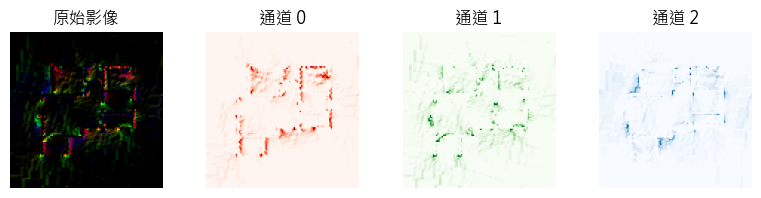

In [43]:
def compute_convective_force(data, rho=1.0):
    """
    計算對流項 F_c = rho * (u · ∇) u
    
    Parameters
    ----------
    data : np.ndarray
        shape = (time, z, y, x, C)
    rho : float
        流體密度
    
    Returns
    -------
    F_c : np.ndarray
        shape = (time, z, y, x, 3)
    """
    dz, dy, dx = CELL_SIZE,CELL_SIZE,CELL_SIZE  # 假設各方向格距相同

    # 取速度分量
    Ux = data[..., DYNAMIC_FIELDS_NAMES.index("Ux")]
    Uy = data[..., DYNAMIC_FIELDS_NAMES.index("Uy")]
    Uz = data[..., DYNAMIC_FIELDS_NAMES.index("Uz")]
    
    # 計算偏導
    dUx_dx = np.gradient(Ux, dx, axis=3)
    dUx_dy = np.gradient(Ux, dy, axis=2)
    dUx_dz = np.gradient(Ux, dz, axis=1)

    dUy_dx = np.gradient(Uy, dx, axis=3)
    dUy_dy = np.gradient(Uy, dy, axis=2)
    dUy_dz = np.gradient(Uy, dz, axis=1)

    dUz_dx = np.gradient(Uz, dx, axis=3)
    dUz_dy = np.gradient(Uz, dy, axis=2)
    dUz_dz = np.gradient(Uz, dz, axis=1)
    
    # 對流項分量
    Fc_x = rho * (Ux*dUx_dx + Uy*dUx_dy + Uz*dUx_dz)
    Fc_y = rho * (Ux*dUy_dx + Uy*dUy_dy + Uz*dUy_dz)
    Fc_z = rho * (Ux*dUz_dx + Uy*dUz_dy + Uz*dUz_dz)
    
    # 組成向量場
    F_c = np.stack([Fc_x, Fc_y, Fc_z], axis=-1)
    return F_c


F_convective = compute_convective_force(dynamic_fields, rho=1.0)
print(F_convective.shape)
plt_HWC_split_channels(F_convective[0,3,:,:,:], histogram=False, max_channels=None)


In [71]:
def plot_residual_stack(residual_norm, z_idx=3, n_steps=10, max_cols=10, cmap='viridis', fill_value=0):
    """
    將殘差隨時間 slice 均勻取 n_steps 個時間步，左右最多 max_cols，超過自動換行上下堆疊。
    最後一行若不滿列數，補 fill_value。
    
    Parameters
    ----------
    residual_norm : np.ndarray
        shape = (time, z, y, x)
    z_idx, y_idx : int
        選定 z 層和 y slice
    n_steps : int
        要抽取的時間步數
    max_cols : int
        每行最多多少張 slice
    cmap : str
        colormap
    fill_value : float
        最後一行補白的值
    """
    n_time = residual_norm.shape[0]
    
    # 均勻抽取 n_steps 個索引
    if n_time <= n_steps:
        time_indices = list(range(n_time))
    else:
        time_indices = np.linspace(0, n_time-1, n_steps, dtype=int)
    
    slices = [residual_norm[t, z_idx, :, :] for t in time_indices]
    H, W = slices[0].shape
    
    # 計算行列數
    n_cols = min(len(slices), max_cols)
    n_rows = int(np.ceil(len(slices) / n_cols))
    
    # 先把每行水平拼接，最後一行若不足則補白
    row_slices = []
    for r in range(n_rows):
        start = r * n_cols
        end = min((r+1) * n_cols, len(slices))
        row = slices[start:end]
        
        # 補白
        n_missing = n_cols - len(row)
        if n_missing > 0:
            # 補白 slice
            fill_slices = [np.full((H, W), fill_value) for _ in range(n_missing)]
            row.extend(fill_slices)
        
        row_concat = np.concatenate(row, axis=1)
        row_slices.append(row_concat)
    
    stacked = np.concatenate(row_slices[::-1], axis=0)
    
    # plot
    plt.figure(figsize=(4*n_cols, 3*n_rows))
    plt.imshow(stacked, cmap=cmap, origin='lower')
    plt.colorbar(label='Residual norm')
    plt.title(f'Residual norm stacked ({len(time_indices)} time steps)')
    plt.axis('off')
    plt.show()

(35, 32, 105, 103, 3)
(35, 32, 105, 103)
max residual: 12.521628
mean residual: 0.0708147


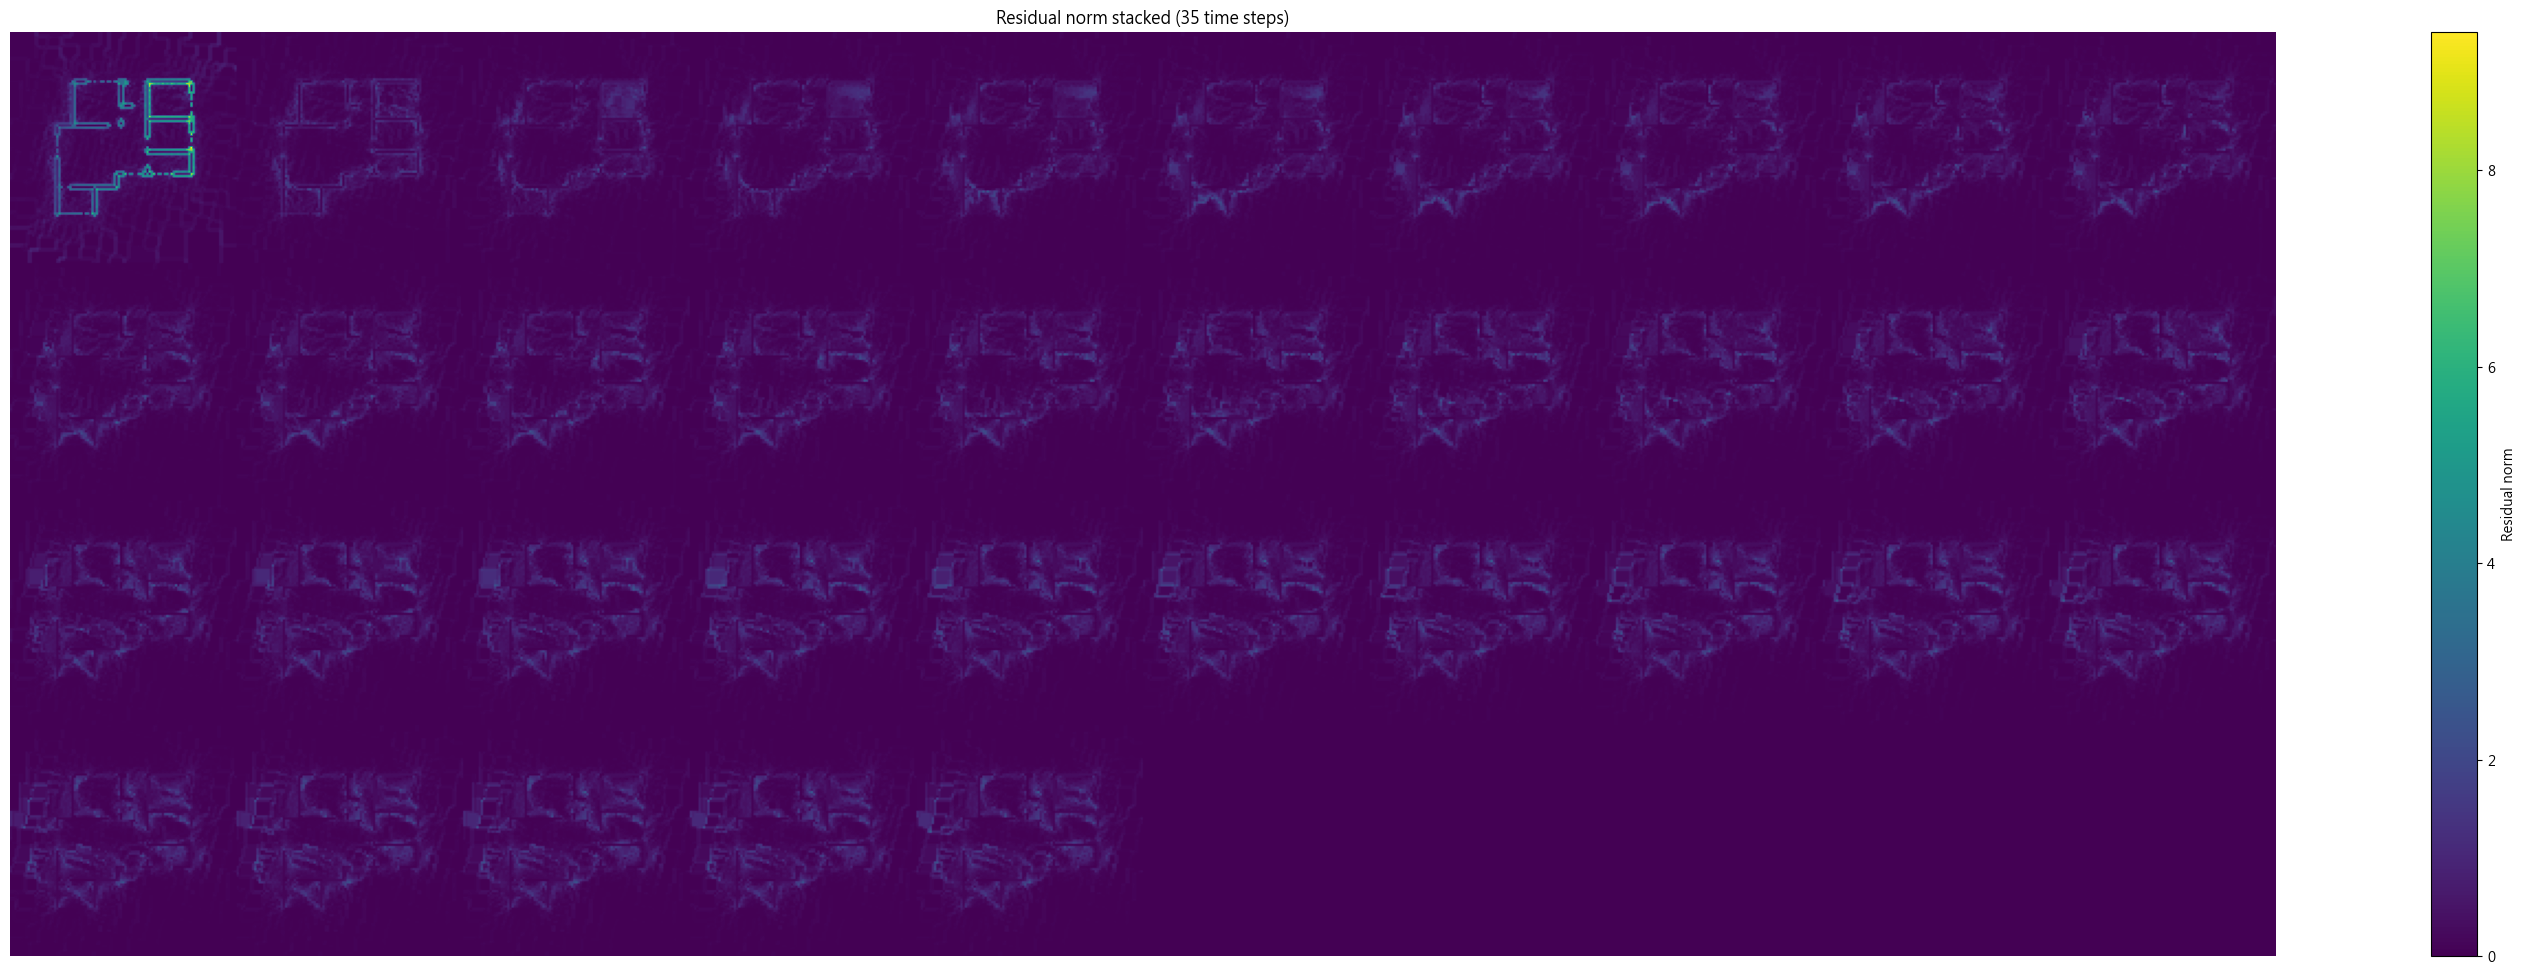

In [73]:
F_total = F_pressure + F_viscous + F_convective  # + F_body if any
residual_norm = np.linalg.norm(F_total, axis=-1)  # shape = (time, z, y, x)
print(F_total.shape)
print(residual_norm.shape)
print("max residual:", np.max(residual_norm))
print("mean residual:", np.mean(residual_norm))

plot_residual_stack(residual_norm, z_idx=3, n_steps=len(residual_norm), max_cols=10, cmap='viridis', fill_value=0)


In [ ]:
import tensorflow as tf
import numpy as np

CHANNEL_N = 16
CELL_FIRE_RATE = 0.5
px, py = 16, 16
NCAModel = CAModel(channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE)

# Blend patch 回 global tensor
def blend_patch(global_tensor, patch_tensor, top_left_coord):
    x0, y0 = top_left_coord
    H, W = patch_tensor.shape[1:3]
    global_tensor[:, y0:y0+H, x0:x0+W, :] = patch_tensor
    return global_tensor

# 計算 residual
def get_patch_residual(patch_tensor):
    return tf.reduce_mean(tf.square(patch_tensor), axis=[1,2,3])

# ======================
# Stack 迴圈版 patch NCA
# ======================
def quadtree_nca_stack(S, max_depth=3, tau=0.01):
    B, H, W, C = S.shape
    S_new = tf.identity(S)

    # stack 存節點資訊: (x0, y0, size, depth)
    stack = [(0, 0, H, 0)]
    
    while stack:
        x0, y0, size, depth = stack.pop()
        
        # slice tensor
        patch = S_new[:, y0:y0+size, x0:x0+size, :]
        
        # NCA 更新
        patch_new = NCAModel(patch)
        
        # 計算 residual
        res = get_patch_residual(patch_new)
        needToDivide = (res > tau) and (depth < max_depth) and (size > px)
        
        if not needToDivide:
            # Leaf node 回寫全域 tensor
            S_new = blend_patch(S_new, patch_new, (x0, y0))
            continue
        
        # Non-leaf → 遞迴細分四個子 patch
        half = size // 2
        # 可選：upsampling 初始化子 patch
        patch_high_res = tf.image.resize(patch_new, [half, half], method='bilinear')
        S_new = blend_patch(S_new, patch_high_res, (x0, y0))
        
        # push 四個子 patch 到 stack
        stack.append((x0, y0, half, depth+1))                  # top-left
        stack.append((x0+half, y0, half, depth+1))            # top-right
        stack.append((x0, y0+half, half, depth+1))            # bottom-left
        stack.append((x0+half, y0+half, half, depth+1))       # bottom-right
        
    return S_new
